In [1]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df['gravité_accident'] = df['gravité_accident']-2
df.info()

# 0: blessé_léger
# 1: blessé_hospitalisé
# 2: tué

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273226 entries, 0 to 273225
Data columns (total 62 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Num_Acc                             273226 non-null  int64 
 1   jour                                273226 non-null  int64 
 2   mois                                273226 non-null  int64 
 3   an                                  273226 non-null  int64 
 4   hrmn                                273226 non-null  object
 5   dep                                 273226 non-null  object
 6   agg                                 273226 non-null  int64 
 7   int                                 273226 non-null  int64 
 8   atm                                 273226 non-null  object
 9   col                                 273226 non-null  int64 
 10  lat                                 273226 non-null  object
 11  long         

Import des bibliothèques nécessaires

In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV


Random Forest

Accuracy du modèle : 0.69
Précision : 0.66
Rappel : 0.69
F1-score : 0.67

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     35156
           1       0.53      0.46      0.49     16400
           2       0.27      0.09      0.14      3090

    accuracy                           0.69     54646
   macro avg       0.52      0.47      0.48     54646
weighted avg       0.66      0.69      0.67     54646



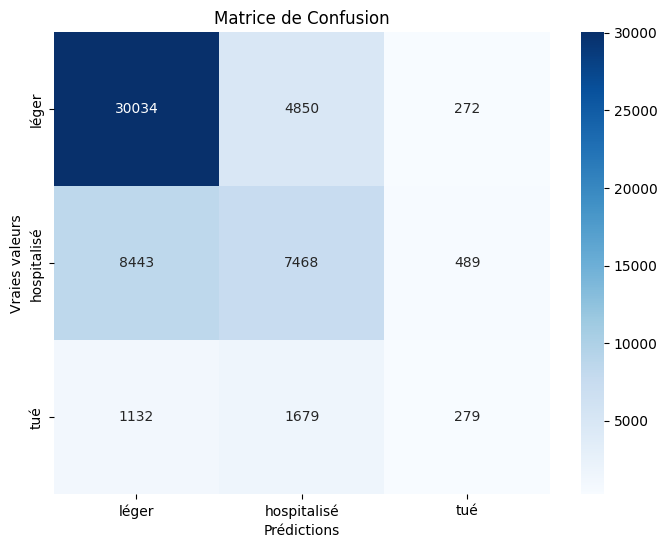

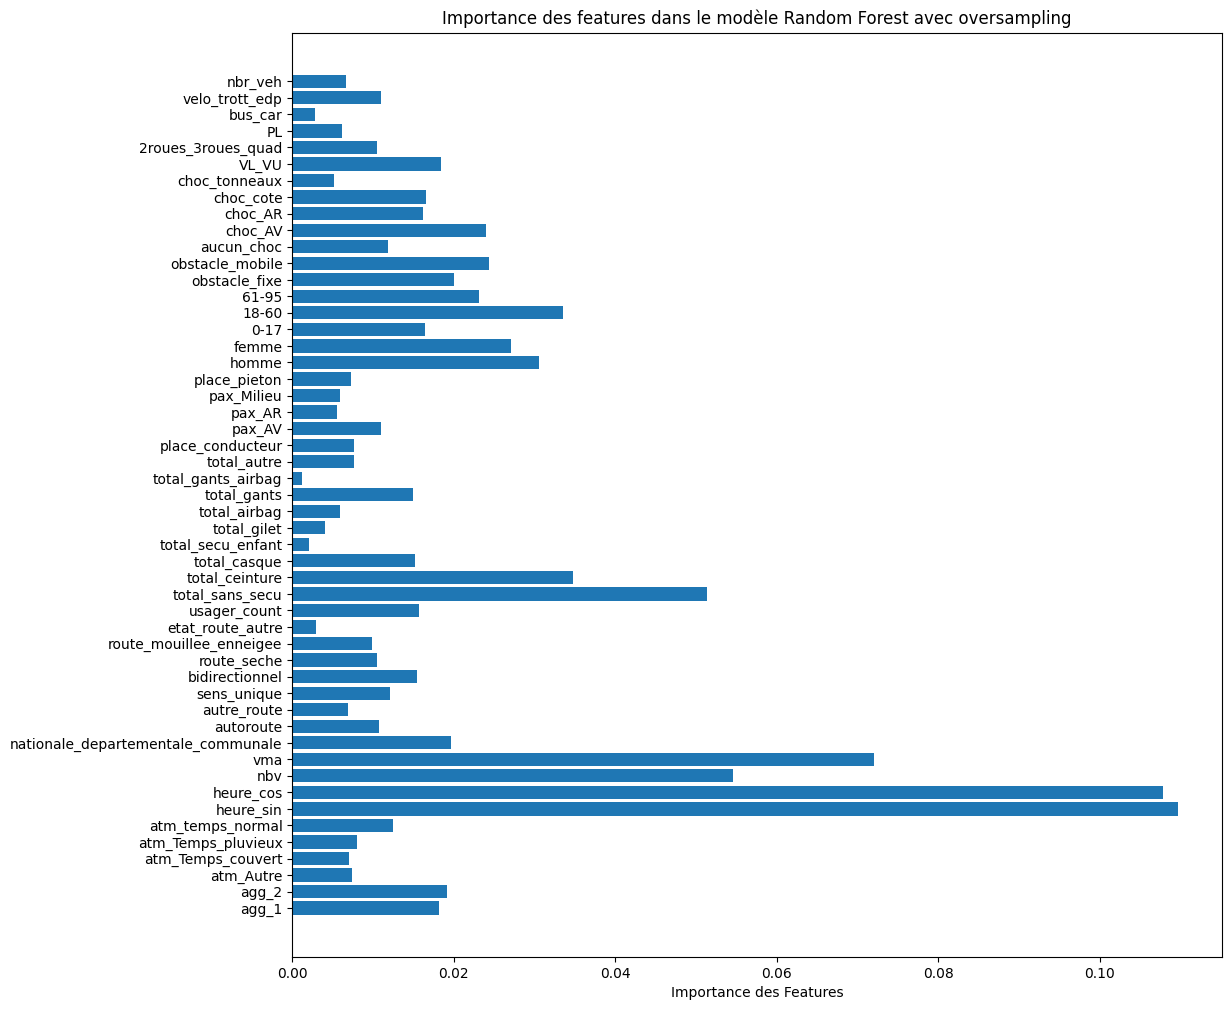

In [ ]:

X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'], yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec oversampling")
plt.show()

Random Forest avec les variables les plus importantes: vma, nbv, heure, total_sans_secu, nationale_communale_departementale

Accuracy du modèle : 0.69
Précision : 0.65
Rappel : 0.69
F1-score : 0.66

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     35156
           1       0.54      0.41      0.47     16400
           2       0.19      0.02      0.03      3090

    accuracy                           0.69     54646
   macro avg       0.49      0.44      0.43     54646
weighted avg       0.65      0.69      0.66     54646



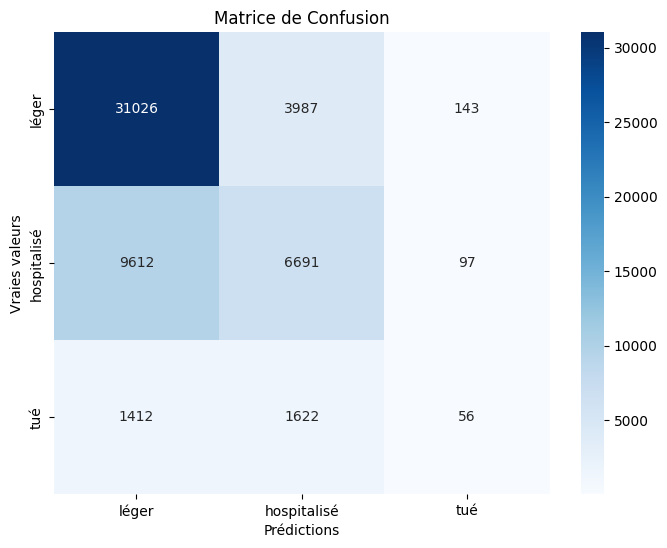

In [ ]:
# Préparation des données
X = df.drop(['Num_Acc', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh','autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche', 'atm',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale',
       'total_sans_secu']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'], yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()




Random Forest avec oversampling


Accuracy du modèle avec oversampling : 0.68
Accuracy du modèle : 0.68
Précision : 0.67
Rappel : 0.68
F1-score : 0.67

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     35156
           1       0.52      0.47      0.50     16400
           2       0.25      0.16      0.20      3090

    accuracy                           0.68     54646
   macro avg       0.51      0.49      0.50     54646
weighted avg       0.67      0.68      0.67     54646



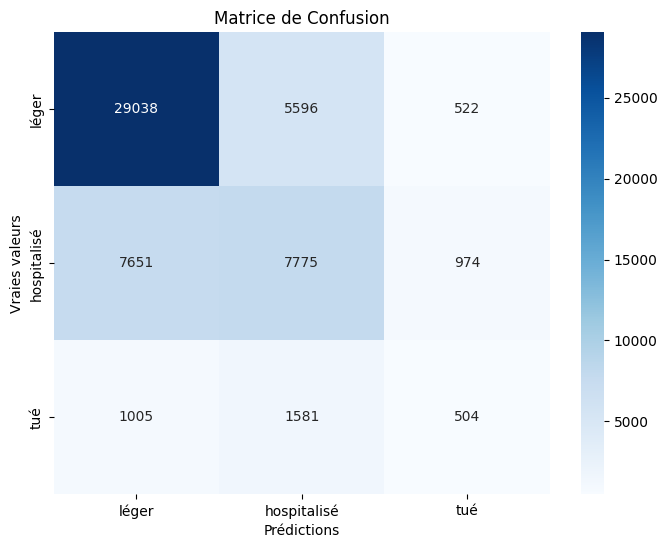

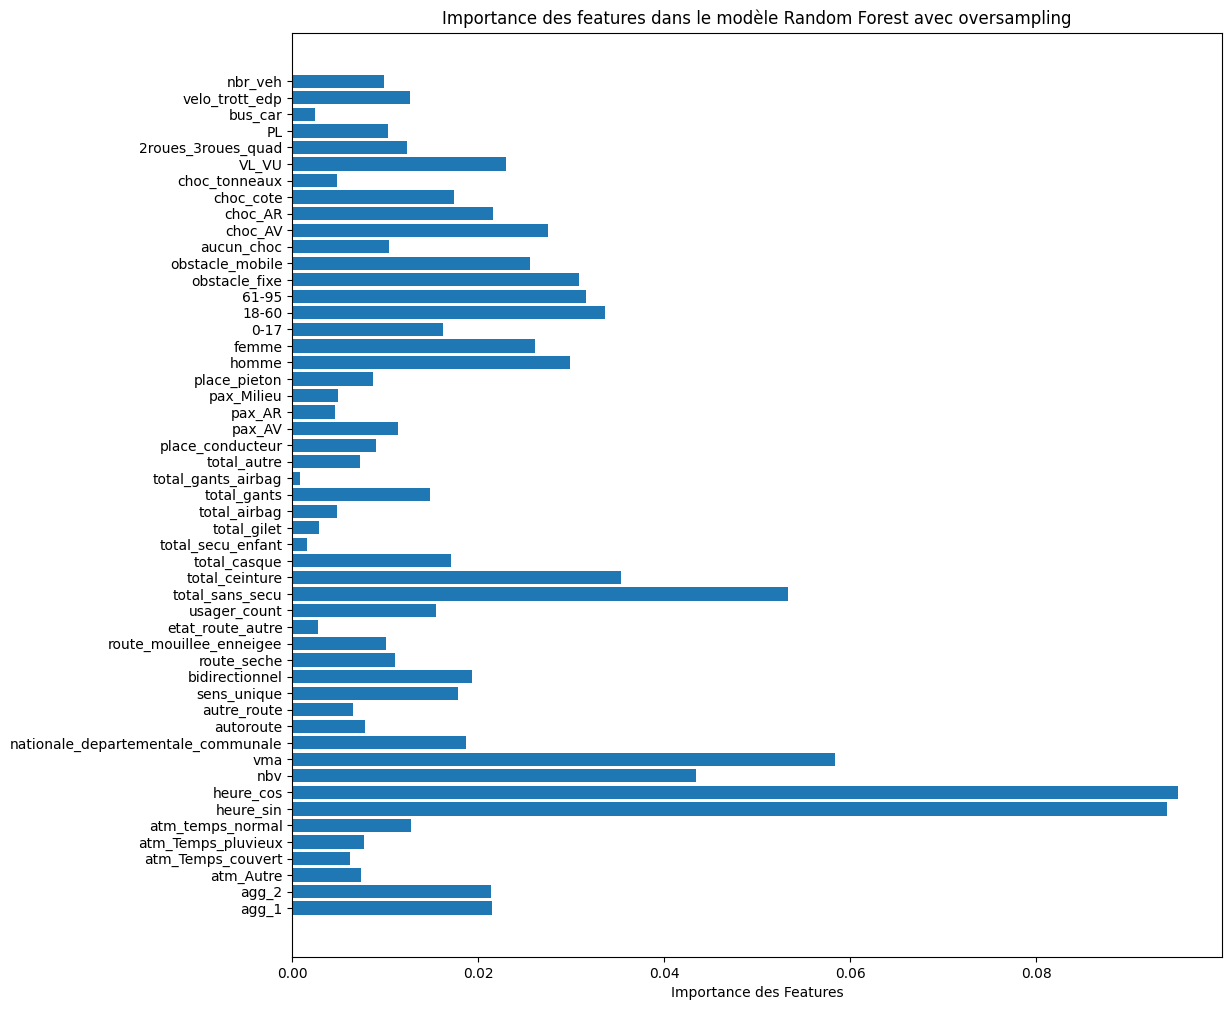

In [ ]:
# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Appliquer SMOTE dans la pipeline (avant l'entraînement du modèle)
smote = SMOTE(random_state=42, sampling_strategy = 'auto', k_neighbors = 5)

# Définir la pipeline complète avec SMOTE
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('smote', smote),  # Oversampling via SMOTE
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classificateur
])

# Entraîner le modèle avec oversampling
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec oversampling : {accuracy:.2f}")

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")



# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)


# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'], yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec oversampling")
plt.show()

Random Forest avec Undersampling

Accuracy du modèle avec undersampling : 0.58
Précision : 0.67
Rappel : 0.58
F1-score : 0.61

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.82      0.67      0.74     35156
           1       0.44      0.39      0.41     16400
           2       0.16      0.58      0.25      3090

    accuracy                           0.58     54646
   macro avg       0.47      0.55      0.47     54646
weighted avg       0.67      0.58      0.61     54646



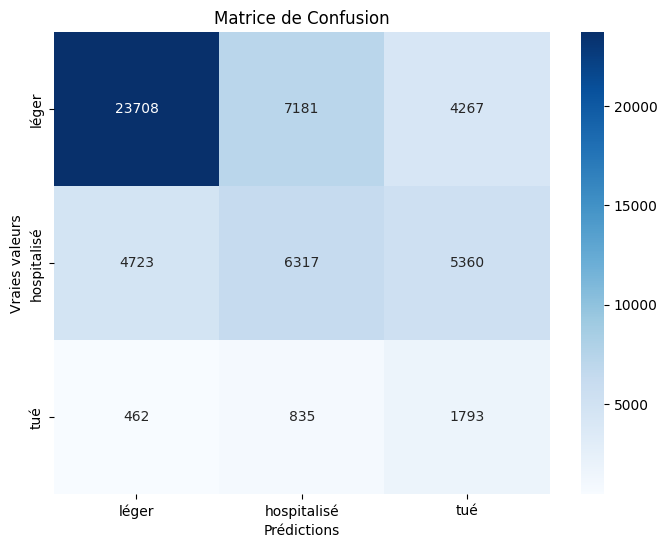

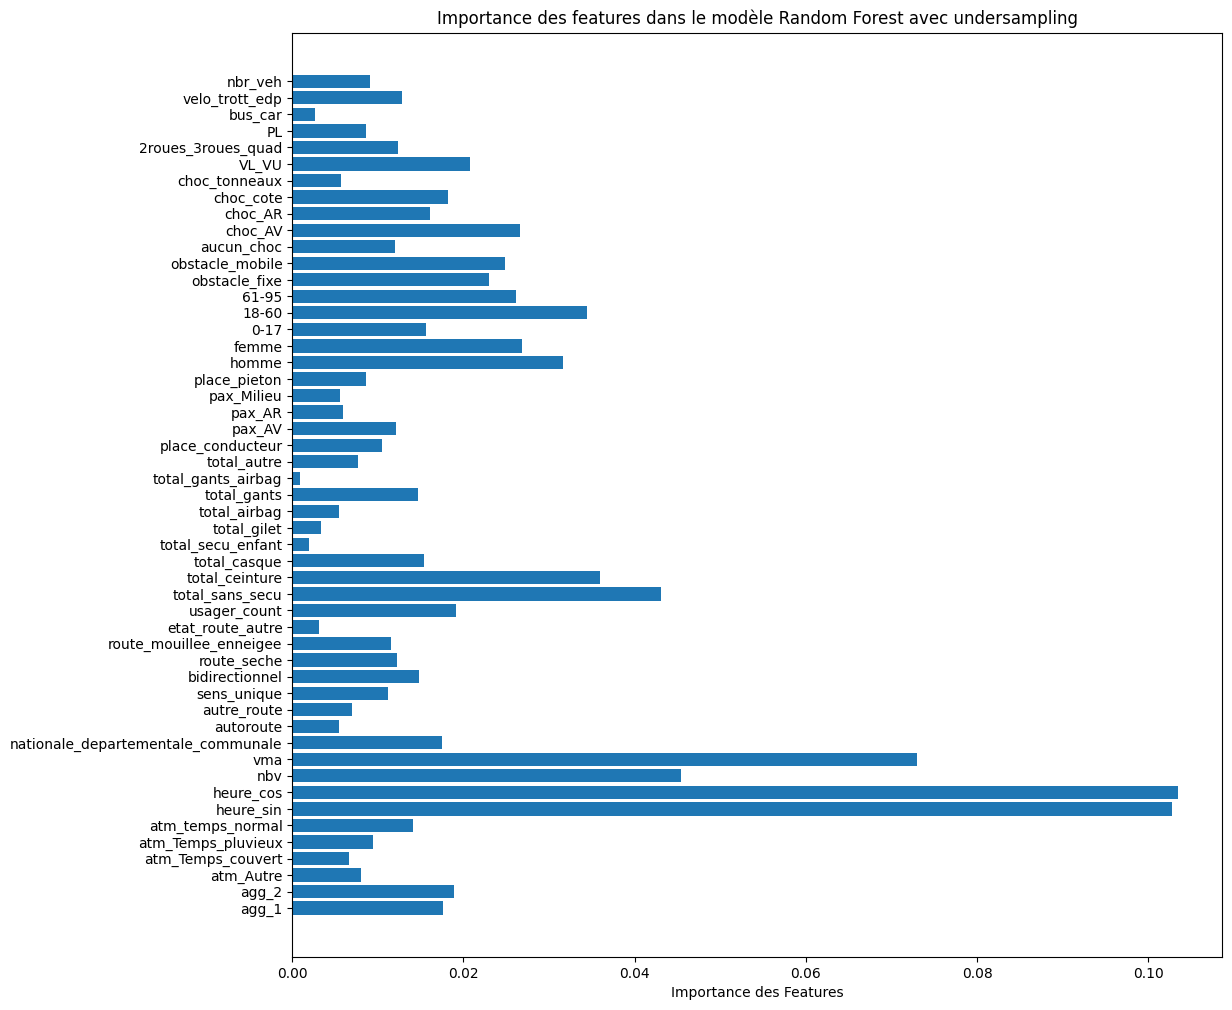

In [ ]:

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')

# Appliquer RandomUnderSampler dans la pipeline (avant l'entraînement du modèle)
under_sampler = RandomUnderSampler(random_state=42)

# Définir la pipeline complète avec undersampling
pipeline = imPipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('under_sampler', under_sampler),  # Undersampling via RandomUnderSampler
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Classificateur
])

# Entraîner le modèle avec undersampling
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle avec undersampling : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'], yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Récupérer l'importance des features
# Récupérer le modèle du classifieur après l'entraînement
model = pipeline.named_steps['classifier']

# Accéder aux importances des features
importances = model.feature_importances_

# Récupérer les noms des features après transformation
# Utiliser l'encodeur OneHotEncoder pour gérer les variables catégorielles encodées
# et la transformation cyclique pour obtenir les noms des features résultants.
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
cyclical_columns = ['heure_sin', 'heure_cos']  # Ces noms sont définis par la transformation de l'heure

# Les noms des features après transformation
features = np.concatenate([cat_columns, cyclical_columns, passthrough_features])

# Tracer l'importance des features
plt.figure(figsize=(12, 12))
plt.barh(features, importances)
plt.xlabel("Importance des Features")
plt.title("Importance des features dans le modèle Random Forest avec undersampling")
plt.show()

Grrid search pour optimiser paramètres du modele avec toutes les variables. Utilisation de class_weight='balanced' pour gérer le déséquilibre des classes

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__n_estimators': 100}

📊 **Performance du modèle optimal**
Accuracy: 0.72
Precision: 0.69
Recall: 0.72
F1-score: 0.69

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82     35156
           1       0.58      0.47      0.52     16400
           2       0.48      0.03      0.06      3090

    accuracy                           0.72     54646
   macro avg       0.61      0.47      0.47     54646
weighted avg       0.69      0.72      0.69     54646



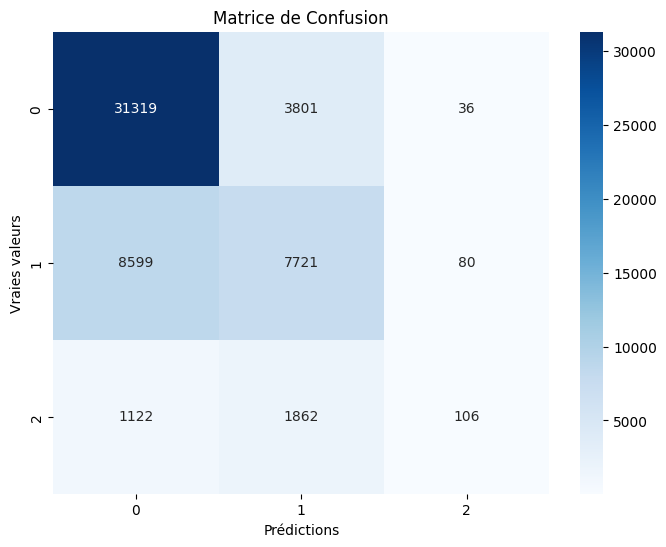

In [ ]:
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']


# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')


# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42,class_weight='balanced')

# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])

# 📌 **Définition de la grille de recherche**
param_grid = {

    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
    'classifier__class_weight': ['balanced', None]  # Tester 'balanced' et None
}

# 📌 **Lancer la GridSearchCV**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()



Grid search en mentionnant qu'on souhaite un meilleur recall pour la classe 1 ( hospitalisé)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__n_estimators': 200}

📊 **Performance du modèle optimal**
Accuracy: 0.68
Precision: 0.69
Recall: 0.68
F1-score: 0.68

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     35156
           1       0.53      0.47      0.50     16400
           2       0.24      0.34      0.28      3090

    accuracy                           0.68     54646
   macro avg       0.52      0.54      0.53     54646
weighted avg       0.69      0.68      0.68     54646



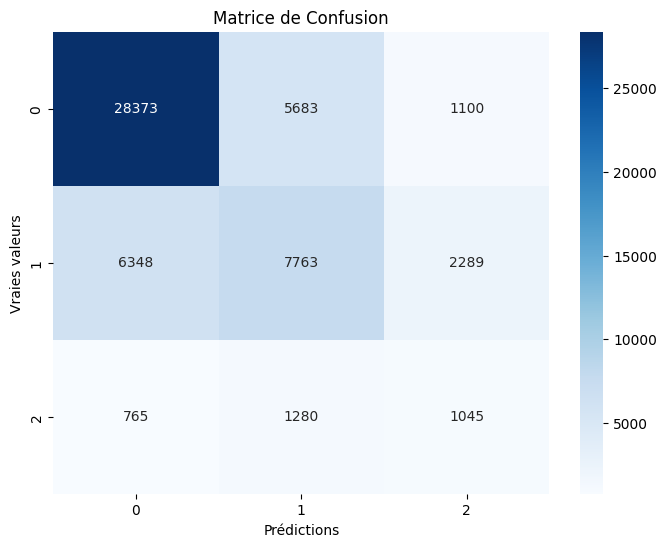

In [3]:
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer X et y
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')


# 📌 **Définir un scorer personnalisé pour optimiser une classe spécifique**
target_class = 1  # Classe à privilégier
custom_scorer = make_scorer(recall_score, average=None, labels=[target_class])  # Rappel pour la classe cible


# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')


# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])


# 📌 **Définition de la grille de recherche**
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
    'classifier__class_weight': ['balanced', None]  # Tester 'balanced' et None
}


# 📌 **Lancer la GridSearchCV avec le scorer personnalisé**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=custom_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


Grid search en mentionnant qu'on souhaite un meilleur F1_score pour la classe 1 ( hospitalisé)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs paramètres: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__n_estimators': 200}

📊 **Performance du modèle optimal**
Accuracy: 0.72
Precision: 0.69
Recall: 0.72
F1-score: 0.69

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82     35156
           1       0.58      0.47      0.52     16400
           2       0.48      0.03      0.07      3090

    accuracy                           0.72     54646
   macro avg       0.61      0.47      0.47     54646
weighted avg       0.69      0.72      0.69     54646



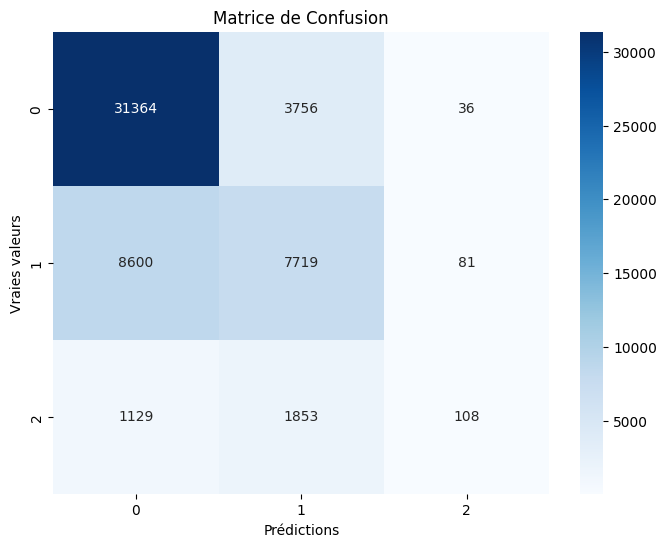

In [4]:
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer X et y
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées


# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')


# 📌 **Définir un scorer personnalisé pour optimiser le F1-score de la classe 1 (hospitalisé)**
def class_specific_f1_score(y_true, y_pred, class_index=1):
    return f1_score(y_true, y_pred, labels=[class_index], average='micro')

# Crée un scorer personnalisé basé sur F1-score pour la classe 1
custom_f1_scorer = make_scorer(class_specific_f1_score, class_index=1)


# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')


# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])


# 📌 **Définition de la grille de recherche**
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
    'classifier__class_weight': ['balanced', None]  # Tester 'balanced' et None
}


# 📌 **Lancer la GridSearchCV avec le scorer personnalisé**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=custom_f1_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


GridSearch avec les variables les plus importantes pour optimiser les paramètres du modèle et class_weight = 'balanced' pour gérer le déséquilibre des classes automatiquement

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Meilleurs paramètres: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}

📊 **Performance du modèle optimal**
Accuracy: 0.70
Precision: 0.67
Recall: 0.70
F1-score: 0.66

Rapport de Classification:
              precision    recall  f1-score   support

           2       0.73      0.91      0.81     35156
           3       0.57      0.38      0.46     16400
           4       0.45      0.00      0.01      3090

    accuracy                           0.70     54646
   macro avg       0.58      0.43      0.42     54646
weighted avg       0.67      0.70      0.66     54646



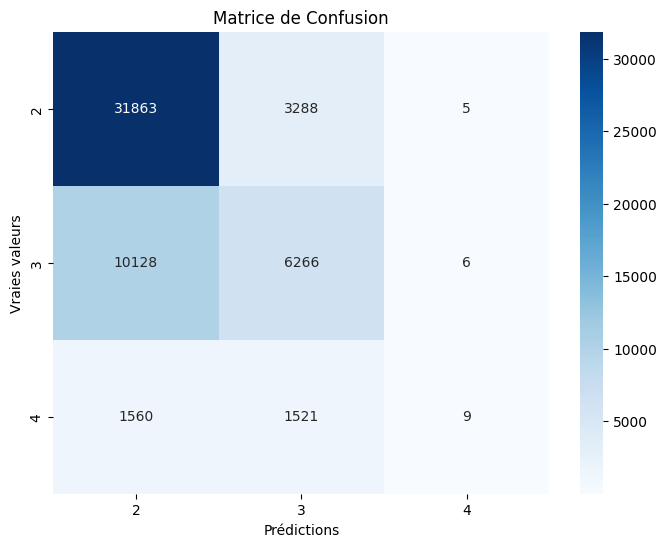

In [ ]:

# Préparation des données
X = df.drop(['Num_Acc', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh','autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche', 'atm',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count','lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 📌 **Définition des variables**
categorical_features = ['agg']
cyclical_features = ['heure']
passthrough_features = ['nbv', 'vma']

# 📌 **Pipeline de preprocessing**
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
], remainder='passthrough')

# 📌 **Modèle de classification**
classifier = RandomForestClassifier(random_state=42, class_weight = 'balanced')

# 📌 **Pipeline principal avec imblearn Pipeline**
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Étape de transformation
    ('classifier', classifier)  # Modèle final
])

# 📌 **Définition de la grille de recherche**
param_grid = {

    'classifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
    'classifier__max_depth': [10, 20, None],  # Profondeur maximale
}

# 📌 **Lancer la GridSearchCV**
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 **Afficher les meilleurs paramètres**
print("Meilleurs paramètres:", grid_search.best_params_)

# 📌 **Évaluation du modèle optimal**
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)



accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

Recherche meilleurs poids pour la métrique personnalisée "précision"

Configuration des poids {0: 1, 1: 2, 2: 3} -> Précision pondérée : 0.6690984034671896
Configuration des poids {0: 1, 1: 5, 2: 5} -> Précision pondérée : 0.6519021874319841
Configuration des poids {0: 1, 1: 5, 2: 10} -> Précision pondérée : 0.6675422002409942
Configuration des poids {0: 1, 1: 3, 2: 3} -> Précision pondérée : 0.656962116500784

Meilleure configuration de pondération : {0: 1, 1: 2, 2: 3}

📊 **Performance du modèle optimal**
Accuracy: 0.70
Precision pondérée avec les poinds optimaux: 0.7039437097081395
Recall: 0.70
F1-score: 0.69

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     35156
           1       0.52      0.62      0.57     16400
           2       0.56      0.02      0.04      3090

    accuracy                           0.70     54646
   macro avg       0.63      0.48      0.47     54646
weighted avg       0.70      0.70      0.69     54646



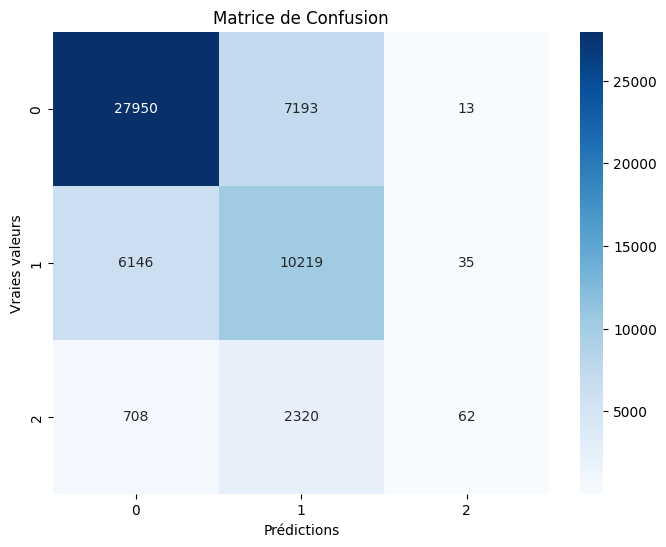

In [ ]:
# Meilleurs paramètres: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}

# ON va créer une métrique personnalisée qui donne plus de poids à la prédiction '1': blessé hospitalisé

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')


# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre', 'place_conducteur',
                        'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux',
                        'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)],
    remainder='passthrough')  # Laisser les autres variables inchangées

# Définir les différentes pondérations à tester
class_weights_list = [
    {0: 1, 1: 2, 2: 3},
    {0: 1, 1: 5, 2:5},
    {0: 1, 1: 5, 2:10},
    {0: 1, 1: 3, 2:3},
]


# Définir une fonction pour la précision pondérée
def weighted_precision(y_true, y_pred, class_weights):
    from sklearn.metrics import precision_score
    # Calculer la précision pour chaque classe
    precision_per_class = precision_score(y_true, y_pred, average=None)

    # Associer les poids aux classes dans le même ordre que dans precision_per_class
    weights = [class_weights.get(i, 1) for i in range(len(precision_per_class))]

    # Calculer la précision pondérée en fonction des poids
    weighted_precision = np.dot(precision_per_class, weights) / sum(weights)
    return weighted_precision


# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42))  # Classificateur
])

# Pour chaque configuration de poids, effectuer une validation croisée et calculer la précision pondérée
results = {}

for class_weights in class_weights_list:
    # Utiliser cross_val_score pour évaluer la performance avec les poids de classes
    precision_scores = cross_val_score(
        pipeline, X_train, y_train, cv=5,
        scoring=lambda est, X, y: weighted_precision(y, est.predict(X), class_weights)
    )

    # Enregistrer la moyenne des scores de précision pondérée
    results[str(class_weights)] = np.mean(precision_scores)

# Afficher les résultats pour chaque configuration de pondération
for class_weights, score in results.items():
    print(f"Configuration des poids {class_weights} -> Précision pondérée : {score}")

# Trouver la configuration qui donne la meilleure précision pondérée
best_class_weights = max(results, key=results.get)
print(f"\nMeilleure configuration de pondération : {best_class_weights}")

# Créer la pipeline en utilisant les poids optimaux dans le classificateur RandomForest
pipeline_with_optimal_weights = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=42,
        class_weight=eval(best_class_weights)  # Appliquer les poids ici, eval permet de convertir best_class_weight en un dictionnaire
    ))
])

# Entraîner le modèle avec les poids optimaux
pipeline_with_optimal_weights.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline_with_optimal_weights.predict(X_test)

# Evaluation de la performance du modèle

accuracy = accuracy_score(y_test, y_pred)
precision_optimale = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision pondérée avec les poinds optimaux: {precision_optimale}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


Recherche meilleurs poids pour la métrique personnalisée "F1-Score"

Configuration des poids {0: 1, 1: 2, 2: 1} -> Précision pondérée : 0.44670245271593345
Configuration des poids {0: 1, 1: 10, 2: 5} -> Précision pondérée : 0.3539732055397752
Configuration des poids {0: 1, 1: 10, 2: 10} -> Précision pondérée : 0.27334463537080333

Meilleure configuration de pondération : {0: 1, 1: 2, 2: 1}

📊 **Performance du modèle optimal**
Accuracy: 0.70
Precision: 0.70
Recall: 0.70
F1-score pondéré avec les poids optimaux: 0.6825473378851216

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     35156
           1       0.52      0.62      0.57     16400
           2       0.50      0.00      0.00      3090

    accuracy                           0.70     54646
   macro avg       0.61      0.47      0.45     54646
weighted avg       0.70      0.70      0.68     54646



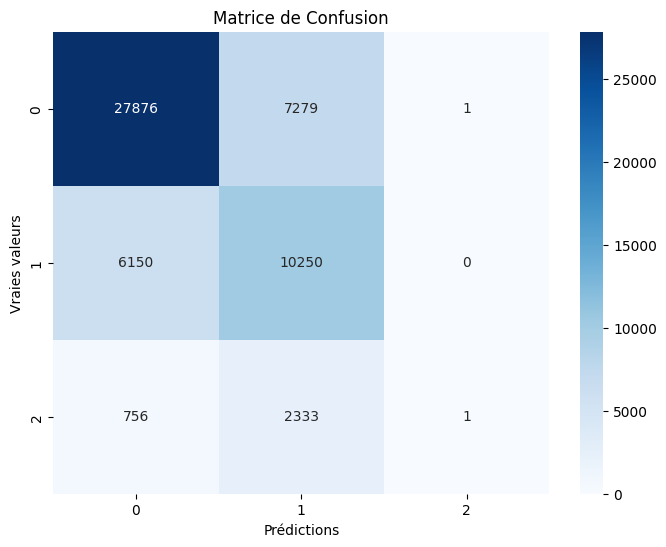

In [ ]:
 # Meilleurs paramètres: {'classifier__max_depth': 10, 'classifier__n_estimators': 50}

# ON va créer une métrique personnalisée qui donne plus de poids à la prédiction '3': blessé hospitalisé

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
       'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)], remainder='passthrough')


# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger',
             'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee', 'etat_route_autre',
                        'usager_count', 'total_sans_secu', 'total_ceinture', 'total_casque', 'total_secu_enfant',
                        'total_gilet', 'total_airbag', 'total_gants', 'total_gants_airbag', 'total_autre', 'place_conducteur',
                        'pax_AV', 'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux',
                        'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)],
    remainder='passthrough')  # Laisser les autres variables inchangées

# Définir les différentes pondérations à tester
class_weights_list = [
    {0: 1, 1: 2, 2: 1},
    {0: 1, 1: 10, 2:5},
    {0: 1, 1: 10, 2:10},
    {0: 1, 1: 10, 2:5},
]

# Définir une fonction pour la précision pondérée
def weighted_f1_score(y_true, y_pred, class_weights):
    # Calculer la précision pour chaque classe
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Associer les poids aux classes dans le même ordre que dans precision_per_class
    weights = [class_weights.get(i, 1) for i in range(len(f1_per_class))]

    # Calculer la précision pondérée en fonction des poids
    weighted_f1 = np.dot(f1_per_class, weights) / sum(weights)
    return weighted_f1


# Définir la pipeline complète
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42))  # Classificateur
])

# Pour chaque configuration de poids, effectuer une validation croisée et calculer la précision pondérée
results = {}

for class_weights in class_weights_list:
    # Utiliser cross_val_score pour évaluer la performance avec les poids de classes
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=lambda est, X, y: weighted_f1_score(y, est.predict(X), class_weights)
    )

    # Enregistrer la moyenne des scores de précision pondérée
    results[str(class_weights)] = np.mean(f1_scores)

# Afficher les résultats pour chaque configuration de pondération
for class_weights, score in results.items():
    print(f"Configuration des poids {class_weights} -> Précision pondérée : {score}")

# Trouver la configuration qui donne la meilleure précision pondérée
best_class_weights = max(results, key=results.get)
print(f"\nMeilleure configuration de pondération : {best_class_weights}")

# Créer la pipeline en utilisant les poids optimaux dans le classificateur RandomForest
pipeline_with_optimal_weights = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=42,
        class_weight=eval(best_class_weights) # Appliquer les poids ici
    ))
])

# Entraîner le modèle avec les poids optimaux
pipeline_with_optimal_weights.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline_with_optimal_weights.predict(X_test)

# Evaluation de la performance du modèle

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_optimal = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score pondéré avec les poids optimaux: {f1_optimal}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()



Recherche meilleurs poids pour la métrique personnalisée "Recall"

Configuration des poids {0: 1, 1: 2, 2: 1} -> Rappel pondéré : 0.43160848418020964
Configuration des poids {0: 1, 1: 10, 2: 5} -> Rappel pondéré : 0.3113245375793031
Configuration des poids {0: 1, 1: 10, 2: 10} -> Rappel pondéré : 0.23904561744646738

Meilleure configuration de pondération (Rappel) : {0: 1, 1: 2, 2: 1}

📊 **Performance du modèle optimal**
Accuracy: 0.70
Precision: 0.70
Recall_optimal: 0.70
F1-score:  0.68

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     35156
           1       0.52      0.62      0.57     16400
           2       0.50      0.00      0.00      3090

    accuracy                           0.70     54646
   macro avg       0.61      0.47      0.45     54646
weighted avg       0.70      0.70      0.68     54646



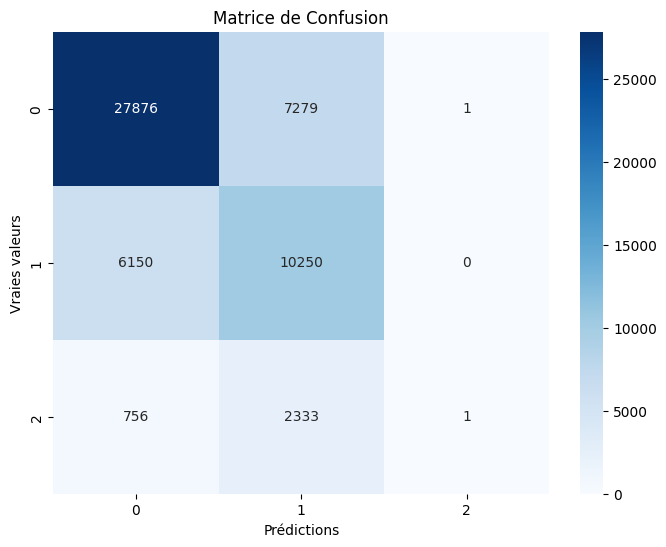

In [ ]:
from sklearn.metrics import recall_score

# Définir une fonction pour le rappel pondéré
def weighted_recall(y_true, y_pred, class_weights):
    # Calculer le rappel pour chaque classe
    recall_per_class = recall_score(y_true, y_pred, average=None)

    # Associer les poids aux classes dans le même ordre que dans recall_per_class
    weights = [class_weights.get(i, 1) for i in range(len(recall_per_class))]

    # Calculer le rappel pondéré en fonction des poids
    weighted_recall_score = np.dot(recall_per_class, weights) / sum(weights)
    return weighted_recall_score

# Définir les différentes pondérations à tester (déjà définies dans ton code précédent)
class_weights_list = [
    {0: 1, 1: 2, 2: 1},
    {0: 1, 1: 10, 2:5},
    {0: 1, 1: 10, 2:10},
    {0: 1, 1: 10, 2:5},
]


# Initialiser un dictionnaire pour stocker les résultats du rappel pondéré
results_recall = {}

# Pour chaque configuration de poids, effectuer une validation croisée et calculer le rappel pondéré
for class_weights in class_weights_list:
    # Utiliser cross_val_score pour évaluer la performance avec les poids de classes
    recall_scores = cross_val_score(
        pipeline, X_train, y_train, cv=5,
        scoring=lambda est, X, y: weighted_recall(y, est.predict(X), class_weights)
    )

    # Enregistrer la moyenne des scores de rappel pondéré
    results_recall[str(class_weights)] = np.mean(recall_scores)

# Afficher les résultats pour chaque configuration de pondération
for class_weights, score in results_recall.items():
    print(f"Configuration des poids {class_weights} -> Rappel pondéré : {score}")

# Trouver la configuration qui donne le meilleur rappel pondéré
best_class_weights_recall = max(results_recall, key=results_recall.get)
print(f"\nMeilleure configuration de pondération (Rappel) : {best_class_weights_recall}")

# Créer la pipeline en utilisant les poids optimaux dans le classificateur RandomForest
pipeline_with_optimal_weights = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=42,
        class_weight=eval(best_class_weights) # Appliquer les poids ici
    ))
])

# Entraîner le modèle avec les poids optimaux
pipeline_with_optimal_weights.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline_with_optimal_weights.predict(X_test)

# Evaluation de la performance du modèle

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall_optimal = recall_score(y_test, y_pred, average='weighted')
f1_score = f1_score(y_test, y_pred, average='weighted')

print("\n📊 **Performance du modèle optimal**")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall_optimal: {recall:.2f}")
print(f"F1-score: {f1_score: .2f}")
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# 📌 **Matrice de confusion**
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()